The Plan (tm):
plot more variables for Ecal and recoil tracker, for guns of 0.1,0.5,1.0 GeV and for flat sample:

plot the variable as function of kinetic energy
Variables:

&ensp;shower max (which layer in ecal/recoil tracker has the most energy deposited in it)

&ensp;average depth (how far in z the particle goes) "Is this endz or the furthest recorded z in simhits/rechits? Also do we want the average?"

&ensp;energy sum

&ensp;energy average

&ensp;make dE/dz plots that include both pions and protons: i.e. make it scatter plot of different color?

&ensp;make dE/dz plot as a function of energy deposition (i.e. dz = how close you are to the maximum of the shower) "To the maximum of the shower? or to the last recorded layer?"

&ensp;investigate what is happening with RecHits as function of layer (what is around layer = 5 and layer = 24?) "How to investigate?"

In [1]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [2]:
with uproot.open("data/protonpion_Oct5/ntuple_gps_proton_100.00-2000.00MeV_50k_target_events_r0007_b2_104.root") as file:
    print(file["Events"]["Sim_Particle_kine"].array())

[[717], [751], [383], [119], ... [1.71e+03], [1.6e+03], [205], [1.07e+03]]


In [3]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

#getting rid of hits that occur at later times and earlier layers and looking at path length
#Path will only contain the first occurence of every tracker hit
def dontlookback(arr, mask=[[],[]], Start=0):
    if not ak.any(mask): mask=[[True for y in x] for x in arr]#[[True for j in i] if ak.any(i) else [False for j in i] for i in arr]
    Path=[]
    for evt1, evt2 in zip(arr, mask):
        mx=Start
        eventMask=[]
        for hit1, hit2 in zip(evt1, evt2):
            if hit1<=mx: hit2=False
            elif hit1>mx: mx=hit1
            eventMask.append(hit2)
        
        if not any(eventMask): eventMask[0]=True 
        Path.append(eventMask)
    return ak.Array(Path)
  
#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)
        
def wifMap(layerArr, zArr, mask, lead=0, oneIndexed=False):
    #Creates array of layer widths and positions. The layer number is the index to the respective values.
    numlay=ak.max(layerArr, axis=None)+1-oneIndexed
    layerZ=np.zeros(numlay)
    layerSpacing=np.zeros(numlay)
    layerSpacing[0]=lead
    #Populates layerZs and layerSpacing
    for evt1, evt2 in zip(layerArr[mask], zArr[mask]):
        for hit1, hit2 in zip(evt1, evt2):
            #layerZs
            if layerZ[hit1-oneIndexed]==0: layerZ[hit1-oneIndexed]=hit2
            #layerSpacing
            if layerSpacing[hit1-oneIndexed]==0 and layerZ[hit1-1-oneIndexed]!=0: layerSpacing[hit1-oneIndexed]=hit2-layerZ[hit1-1-oneIndexed]
            #Break if lists are done being filled
            if all(layerSpacing!=0): break    
        if all(layerSpacing!=0): break
            
    #Creates 2D array of layer widths, with same shape as layerArr, to calculate dE/dz
    WidthMap=[]
    for evt in layerArr:
        evtMask=[]
        for hit in evt:
            evtMask.append(layerSpacing[hit-oneIndexed])
        WidthMap.append(evtMask)
    
    WidthMap=ak.Array(WidthMap)
    
    return WidthMap, layerZ, layerSpacing
    

#---------------------------------- Histogram Functions---------------------------------------------------
Bins={"Sim_Particle": 
        {'pdgID':[50, 200, 2240], 'trkID':[50, 0, 100], 'mass':[20, 0, 940], 'e':[50, 2000, 3500],
         'kine':[20, 100, 2001], 'px':[50, 0, 20], 'py':[50, 0, 20], 'pz':[50, 2000, 3000],
         'endx':[50, 0, 150],'endy':[50, 0, 150], 'endz':[100, 0, 2000], 'vx':[50, 0, 10],
         'vy':[50, 0, 40], 'vz':[50, 0, 50]},
      
      "Recoil_SimHit": {'x':[50,0, 200], 'y':[50,0, 100], 'z':[50,0, 200], 'px':[50,0, 300],
                      'py':[50,0, 400], 'pz':[100,0, 300], 'pdgid':[100,0, 2500], 'edep':[50,0, 0.4],
                      'pathLength':[50,0, 1.2], 'layer':[10,0, 10]},
    
      "Ecal_SimHit": {'edep':[50, 0, 1], 't':[50, 0, 1400], 'x':[50, 0, 300],
                     'y':[50, 0, 300], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "Ecal_RecHit": 
        {'amp':[50, 0, 3.6], 'e':[50, 0, 100], 't':[20, 0, 1], 
         'x':[50, 0, 250], 'y':[50, 0, 260], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "n":
        {"Sim_Particle":[50, 0, 100], "Recoil_SimHit":[50, 0, 100], 
         'Ecal_SimHit':[50, 0, 90], 'Ecal_RecHit':[50, 0, 80]}
     } 

Labels={"Sim_Particle": 
        {'pdgID':'pdgID', 'trkID':'trkID', 'mass':"Mass [MeV]", 'e':"Energy [MeV]",
         'kine':"Kinetic Energy [MeV]", 'px':r"$p_x$ [MeV]", 'py':r"$p_y$ [MeV]", 'pz':r"$p_z$ [MeV]",
         'endx':r"$End_x$ [mm]",'endy':r"$End_y$ [mm]", 'endz':r"$End_z$ [mm]", 'vx':r"$v_x$ [mm]",
         'vy':r"$v_y$ [mm]", 'vz':r"$v_z$ [mm]"},
        
      "Recoil_SimHit": {'x':'x of Hit [mm]', 'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'px':'x Momentum of Hit [mm]',
                      'py':'y Momentum of Hit [mm]', 'pz':'z Momentum of Hit [mm]', 'pdgid':'pdgID', 
                      'edep':'Energy Deposited [MeV]', 'pathLength':'Path Length [mm]', 'layer':'Layer'},
    
      "Ecal_SimHit": {'edep':"Energy Deposited [MeV]", 't':"Time of Hit [ns]", 'x':'x of Hit [mm]',
                     'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'layer':'Layer'},
    
      "Ecal_RecHit": 
        {'amp':"Amplitude [mA]", 'e':"Energy [MeV]", 't':"Time [s]           ", 
         'x': "x [mm]", 'y':"y [mm]", 'z':"z [mm]", 'layer':"Layer"},
        
      "n":
        {'Sim_Particle':("Number of Hits in Event", "Sim_Particle"),
         'Recoil_SimHit':("Number of Hits in Event", "Recoil_SimHit"),   
         'Ecal_RecHit':("Number of Hits in Event", "Ecal_RecHit"),
         'Ecal_SimHit':("Number of Hits in Event", "Ecal_SimHit")} 
         }



#Makes Dictionary of hist.Hist objects in same layout as ldmx_events, where each attr. becomes a key.
#AttrDict must be a dictionary. Bin layout is determined by Bins 3d array, which is indexed with BinAttr
#and BinKey. Preferably this will be mapped out so that individual histograms may be additioned to attr.
#keys. and/or separate binning may be provided. 
def MakeHists(AttrDict, Bins):
    hists={}
    for coll in AttrDict.keys():
        attrHists={}
        for attr in AttrDict[coll]:
            attrHists[attr]=hist.Hist(coll, 
                    axes=(
                    hist.Cat("particle", "Particle"),
                    hist.Bin("e", attr, *(Bins[coll][attr]))
                    ))
            
        hists[coll]=attrHists
    return hists

#def FillHists

In [4]:
hists=MakeHists(branches, Bins)

histsAdd={}


In [5]:
#-----------------------------------------------------------------------------------------------------------------------
#----------------------------------- Additional Histograms -------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------- 
ecalBins=[248, 253, 266, 274, 288, 297, 312, 321, 337, 346, 362, 371, 387, 396, 411, 421, 436, 445, 461, 470, 486, 495, 511, 520, 539, 552, 571, 583, 603, 615, 634, 647, 666, 679, 700]

#-----------Sim_Particle


#-----------Recoil_SimHit
histsAdd["recoil_dedzMIP"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ [MeV/mm]", 100, 0, 2.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))
histsAdd["recoil_dedzScatter"]={"Proton":np.array([[],[]]), "Pion":np.array([[],[]])}

histsAdd["recoil_sumEdep"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Energy Deposited [MeV]", 100, 0, 2.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_avgEdep"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_showerMax"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Layer with Maximum Energy Deposited", 10, 1, 11),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_depth"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Furthest Layer", 10, 1, 11),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_residualMax"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Relative Distance (r) to Shower Max", 100, -200, 200),
                            hist.Bin("p", "Kinetic Energy [MeV]", 100, 100, 2000)))

histsAdd["recoil_residualLast"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Distance (r) to Final Position", 100, 0, 200),
                            hist.Bin("p", "Kinetic Energy [MeV]", 100, 100, 2000)))

#-----------Ecal_SimHit
histsAdd["ecalSim_dedzMIP"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ [MeV/mm]", 100, 0, 2.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))
histsAdd["ecalSim_dedzScatter"]={"Proton":np.array([[],[]]), "Pion":np.array([[],[]])}

histsAdd["ecalSim_sumEdep"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Energy Deposited [MeV]", 100, 0, 10.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_avgEdep"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_showerMax"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Layer with Maximum Energy Deposited", 34, 0, 34),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_depth"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Furthest Layer", 34, 0, 34),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_residualMax"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Relative Distance (r) to Shower Max", 100, -500, 500),
                            hist.Bin("p", "Kinetic Energy [MeV]", 100, 100, 2000)))

histsAdd["ecalSim_residualLast"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Distance (r) to Final Position", 100, 0, 500),
                            hist.Bin("p", "Kinetic Energy [MeV]", 100, 100, 2000)))

#----------Ecal_RecHit
histsAdd["ecalRec_dedzMIP"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "dE/dZ [MeV/mm]", 100, 0, 20.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))
histsAdd["ecalRec_dedzScatter"]={"Proton":np.array([[],[]]), "Pion":np.array([[],[]])}

histsAdd["ecalRec_sumE"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Energy in Event [MeV]", 100, 0, 50),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_avgE"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy of Event [MeV]", 100, 0, 50),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_amp"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Amplitude of Hit [MeV]", 100, 0, 0.8),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_showerMax"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Layer with Maximum Energy", 34, 0, 34),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_depth"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Furthest Layer", 34, 0, 34),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_residualMax"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 50),
                            hist.Bin("s", "Relative Distance (r) to Shower Max", 100, -500, 500),
                            hist.Bin("p", "Kinetic Energy [MeV]", 100, 100, 2000)))

histsAdd["ecalRec_residualLast"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 50),
                            hist.Bin("s", "Distance (r) to Final Position",100, 0, 500),
                            hist.Bin("p", "Kinetic Energy [MeV]", 100, 100, 2000)))


In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']


#------------------------------------------------------------------------------------------------------------    
#--------------------------------------- DATA MASKS/MANIPULATION --------------------------------------------
#------------------------------------------------------------------------------------------------------------    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
    
    
    #Fills all histograms in "hists" that are regular 1D hists of collection attributes
    for coll in ldmx_events.fields:
        for f in ldmx_events[coll].fields:
            hists[coll][f].fill(particle=par, e= flat(getattr(ldmx_events[coll], f)))
            
    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]
    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ecal_simhit[ecalEmptyMask]
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ecal_rechit[ecalRecEmptyMask]
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #Scatter Masks
    recoilPath=dontlookback(recoil_simhit.layer, recoilIDMask)
    ecalPath=dontlookback(ecal_simhit.layer, Start=-1)
    ecalRecPath=dontlookback(ecal_rechit.layer, Start=-1)

    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalSimMIPMask=ecal_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    #dE/dz for variious data sets
    recoilSiWidth=0.32
    ecalSiWidth=0.5
    ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
    
    #'''
    #NEW ATTRIBUTES FOR DEDZ ADDED TO RECOIL_SIMHITS
    recoil_simhit["dedz"]=recoil_simhit.edep/recoilSiWidth
    #recoil_dedzMIPMask=recoil_simhit.dedz>=.13/recoilSiWidth
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_SIMHITS
    ecal_simhit["dedz"]=ecal_simhit.edep/ecalSiWidth
    #ecal_dedzMIPMask=ecal_simhit.dedz>=.13/ecalSiWidth
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_RECHITS
    widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in ecal_rechit.layer]
    widthMap=ak.Array(widthMap)
    
    ecal_rechit["dedz"]=ecal_rechit.e/widthMap
    #ecal_dedzMIPMask=ecal_rechit.dedz>=.13/widthMap
    #'''
    
    #Range of iteration for kinetic energy 2d plots
    kineRange=np.linspace(100,1981,100)
    
    #------------------------------------Data Anlaysis/Histogram Filling------------------------------------------------
    
    #---------------Sim Particle
    
    
    #---------------Recoil Tracker
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=recoilMIPMask & recoilIDMask
    emptiesIncluded=recoil_simhit[twoDMask]
    #Apply the emptyMask with ak.mask, so that the 1D data alignment is preserved. If you wished to preserve the 
    #2d alignment, you would apply the 2d mask with ak.mask as well. 
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    
    #Fills Scatter Plot
    didz=prepared.dedz
    kines=ak.flatten(sim_particle.kine[recoilEmptyMask])
    kines, dedzKine=ak.broadcast_arrays(kines, didz)
    
    didz=ak.flatten(didz, axis=None)
    kines=ak.flatten(kines, axis=None)
    joint=([didz, kines])
    histsAdd["recoil_dedzScatter"][par]=np.append(histsAdd["recoil_dedzScatter"][par], joint, axis=-1)
    
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        oneDMask=kineMaskLower & kineMaskUpper
        #Changes oneDMask to match recoil_simhit dimensions, since it was redefined to remove empty records. Changes kineMask to 1D
        oneDMask=ak.flatten(oneDMask[ecalEmptyMask], axis=None)
        #Apply the OneDMask, and flatten at axis=0 to get rid of the top level "None" values which were empty arrays 
        noEmpties=ak.flatten(prepared[oneDMask], axis=0)
        
        #Fills MIP dedz 
        dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
        histsAdd["recoil_dedzMIP"].fill(particle=par, e=dedzMIP, s=i)
        
        #Fills Energy Sum and Energy Average
        edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
        edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)
        
        histsAdd["recoil_sumEdep"].fill(particle=par, e=edepSum, s=i)
        histsAdd["recoil_avgEdep"].fill(particle=par, e=edepAvg, s=i)
        
        #Fills Shower Max 
        showerMax=np.zeros(len(noEmpties))
        showerXYZ=np.zeros((len(noEmpties), 3))
        spot=0
        for evt in noEmpties:
            mx=max(evt.edep)
            for hit in evt:
                if hit.edep==mx:
                    showerMax[spot]=(hit.layer)
                    showerXYZ[spot]=[hit.x, hit.y, hit.z]
            spot+=1
        
        histsAdd["recoil_showerMax"].fill(particle=par, e=showerMax, s=i)
        
        #Fills Depth
        depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
        histsAdd["recoil_depth"].fill(particle=par, e=depthMax, s=i)
        
        #Fills ResidualMax and ResidualLast
        des=np.zeros(ak.count(noEmpties.edep, axis=None))
        positionMax=np.zeros(ak.count(noEmpties.edep, axis=None))
        
        Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
        positionLast=np.zeros(ak.count(noEmpties.edep, axis=None))
        
        spot=0
        ev=0
        for evt in noEmpties:
            laymx=Last[ev]
            shwmx=showerXYZ[ev]
            for hit in evt:
                des[spot]=(hit.edep)
                distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
                if hit.z<shwmx[2]: distanceMax=-distanceMax
                positionMax[spot]=distanceMax
                
                distanceLast=np.sqrt((hit.x-laymx.x)**2+(hit.y-laymx.y)**2+(hit.z-laymx.z)**2)
                positionLast[spot]=distanceLast
                spot+=1
            ev+=1
        
        histsAdd["recoil_residualMax"].fill(particle=par, e=des, s=positionMax, p=i)
        histsAdd["recoil_residualLast"].fill(particle=par, e=des, s=positionLast, p=i)
               
          
    print("Recoil Done")
    #'''
    #---------------Ecal_SimHits
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=ecalSimMIPMask
    emptiesIncluded=ecal_simhit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    
    #Fills Scatter Plot
    didz=prepared.dedz
    kines=ak.flatten(sim_particle.kine[ecalEmptyMask])
    kines, dedzKine=ak.broadcast_arrays(kines, didz)
    
    didz=ak.flatten(didz, axis=None)
    kines=ak.flatten(kines, axis=None)
    joint=([didz, kines])
    histsAdd["ecalSim_dedzScatter"][par]=np.append(histsAdd["ecalSim_dedzScatter"][par], joint, axis=-1)
    
    #Looping for Kine Plots
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        oneDMask=kineMaskLower & kineMaskUpper
        oneDMask=ak.flatten(oneDMask[ecalEmptyMask], axis=None)
        noEmpties=ak.flatten(prepared[oneDMask], axis=0)
        
        
        #Fills MIP dedz 
        dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
        histsAdd["ecalSim_dedzMIP"].fill(particle=par, e=dedzMIP, s=i)
        
        #Fills Energy Sum and Energy Average
        edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
        edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)
        
        histsAdd["ecalSim_sumEdep"].fill(particle=par, e=edepSum, s=i)
        histsAdd["ecalSim_avgEdep"].fill(particle=par, e=edepAvg, s=i)

        #Fills Shower Max
        showerMax=np.zeros(ak.num(noEmpties, axis=0))
        showerXYZ=np.zeros((len(noEmpties), 3))
        spot=0
        for evt in noEmpties:
            mx=max(evt.edep)
            for hit in evt:
                if hit.edep==mx:
                    showerMax[spot]=(hit.layer)
                    showerXYZ[spot]=[hit.x, hit.y, hit.z]
            spot+=1
        
        histsAdd["ecalSim_showerMax"].fill(particle=par, e=showerMax, s=i)
        
        #Fills Depth
        depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
        histsAdd["ecalSim_depth"].fill(particle=par, e=depthMax, s=i)
        
        #Fills ResidualMax and ResidualLast
        des=np.zeros(ak.count(noEmpties.edep, axis=None))
        positionMax=np.zeros(ak.count(noEmpties.edep, axis=None))
        
        Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
        positionLast=np.zeros(ak.count(noEmpties.edep, axis=None))
        
        spot=0
        ev=0
        for evt in noEmpties:
            laymx=Last[ev]
            shwmx=showerXYZ[ev]
            for hit in evt:
                des[spot]=(hit.edep)
                distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
                if hit.z<shwmx[2]: distanceMax=-distanceMax
                positionMax[spot]=distanceMax
                
                distanceLast=np.sqrt((hit.x-laymx.x)**2+(hit.y-laymx.y)**2+(hit.z-laymx.z)**2)
                positionLast[spot]=distanceLast
                spot+=1
            ev+=1
        
        histsAdd["ecalSim_residualMax"].fill(particle=par, e=des, s=positionMax, p=i)
        histsAdd["ecalSim_residualLast"].fill(particle=par, e=des, s=positionLast, p=i)
        
        
    print("Ecal SimHit Done")
    #'''
    #---------------Ecal_RecHits
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=ecalRecMIPMask
    emptiesIncluded=ecal_rechit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    
    #Fills Scatter Plot
    didz=prepared.dedz
    kines=ak.flatten(sim_particle.kine[ecalRecEmptyMask])
    kines, dedzKine=ak.broadcast_arrays(kines, didz)
    
    didz=ak.flatten(didz, axis=None)
    kines=ak.flatten(kines, axis=None)
    joint=([didz, kines])
    histsAdd["ecalRec_dedzScatter"][par]=np.append(histsAdd["ecalRec_dedzScatter"][par], joint, axis=-1)
    
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        oneDMask=kineMaskLower & kineMaskUpper
        oneDMask=ak.flatten(oneDMask[ecalRecEmptyMask], axis=None)
        noEmpties=ak.flatten(prepared[oneDMask], axis=0)
        
        #Fills MIP dedz 
        dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
        histsAdd["ecalRec_dedzMIP"].fill(particle=par, e=dedzMIP, s=i)
        
        #Fills Energy Sum and Energy Average
        sumE=ak.flatten(ak.sum(noEmpties.e, axis=1), axis=None)
        avgE=ak.flatten(ak.mean(noEmpties.e, axis=1), axis=None)
        
        histsAdd["ecalRec_sumE"].fill(particle=par, e=sumE, s=i)
        histsAdd["ecalRec_avgE"].fill(particle=par, e=avgE, s=i)
        
        #Fills ampKine
        ampWifMap=(widthMap[ecalRecMIPMask])[oneDMask]
        avgAmp=ak.flatten(noEmpties.amp, axis=None)/ak.flatten(ampWifMap, axis=None)
        histsAdd["ecalRec_amp"].fill(particle=par, e=avgAmp, s=i)
        
        #Fills Shower Max
        showerMax=np.zeros(len(noEmpties))
        showerXYZ=np.zeros((len(noEmpties), 3))
        spot=0
        for evt in noEmpties:
            mx=max(evt.e)
            for hit in evt:
                if hit.e==mx: 
                    showerMax[spot]=(hit.layer)
                    showerXYZ[spot]=[hit.x, hit.y, hit.z]
            spot+=1
        
        histsAdd["ecalRec_showerMax"].fill(particle=par, e=showerMax, s=i)
        
        #Fills Depth
        depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
        histsAdd["ecalRec_depth"].fill(particle=par, e=depthMax, s=i)
        
        #Fills ResidualMax and ResidualLast
        des=np.zeros(ak.count(noEmpties.e, axis=None))
        positionMax=np.zeros(ak.count(noEmpties.e, axis=None))
        
        Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
        positionLast=np.zeros(ak.count(noEmpties.e, axis=None))
        
        spot=0
        ev=0
        for evt in noEmpties:
            laymx=Last[ev]
            shwmx=showerXYZ[ev]
            for hit in evt:
                des[spot]=(hit.e)
                distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
                if hit.z<shwmx[2]: distanceMax=-distanceMax
                positionMax[spot]=distanceMax
                
                distanceLast=np.sqrt((hit.x-laymx.x)**2+(hit.y-laymx.y)**2+(hit.z-laymx.z)**2)
                positionLast[spot]=distanceLast
                spot+=1
            ev+=1
        
        histsAdd["ecalRec_residualMax"].fill(particle=par, e=des, s=positionMax, p=i)
        histsAdd["ecalRec_residualLast"].fill(particle=par, e=des, s=positionLast, p=i)
        
    
    print("Ecal RecHit Done")
    #'''
    #------------------------------------------------------------------------------------------


In [7]:
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Oct5/*.root")

start=process_time()
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)
    
stop=process_time()
print("Elapsed time during the whole program in seconds:", stop-start) 

process 1
[[True], [True, True, True, True, ... True, True, True, True, True, True, True]]
Recoil Done
Ecal SimHit Done
Ecal RecHit Done
process 2
[[True, False, False, False, True, False, ... True, True, True, True, True, True]]
Recoil Done
Ecal SimHit Done
Ecal RecHit Done
process 3
[[True, True, True], [True, True, ... True, True, True, True, True, True, True]]
Recoil Done
Ecal SimHit Done
Ecal RecHit Done
process 4
[[True, True, True, True, True, True, True, ... True, True, True, True], [True]]
Recoil Done
Ecal SimHit Done
Ecal RecHit Done
process 5
[[True, False, False, True, False, False, False, ... [True, True, True], [True]]
Recoil Done
Ecal SimHit Done
Ecal RecHit Done
process 6
[[True, True, True], [True, True, True, ... False, False, False], [True, True]]
Recoil Done
Ecal SimHit Done
Ecal RecHit Done
Elapsed time during the whole program in seconds: 714.765625


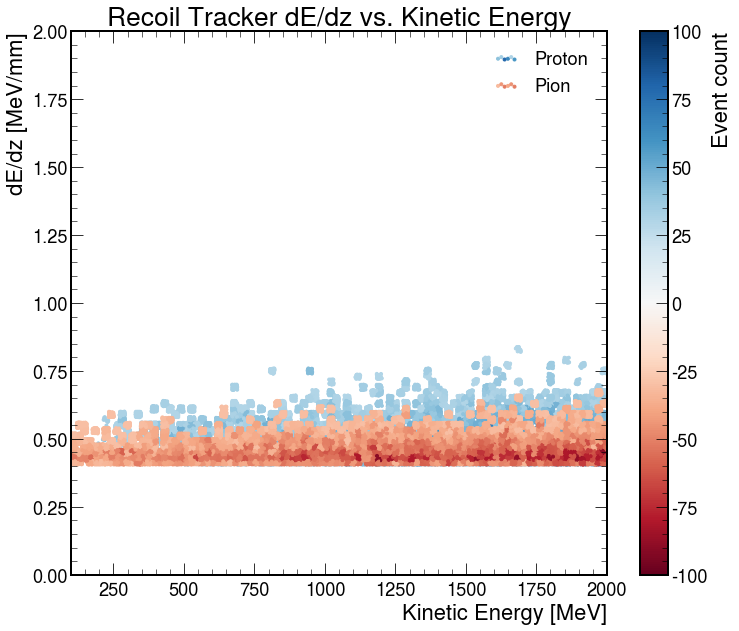

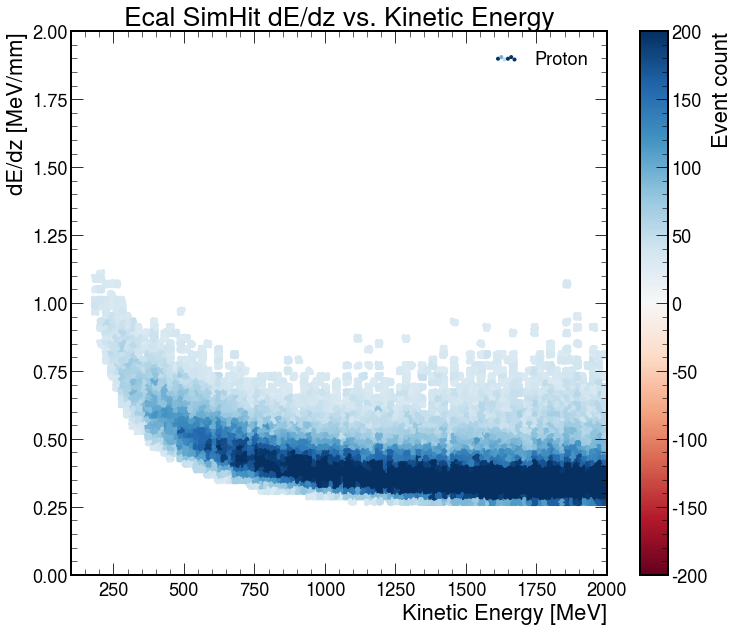

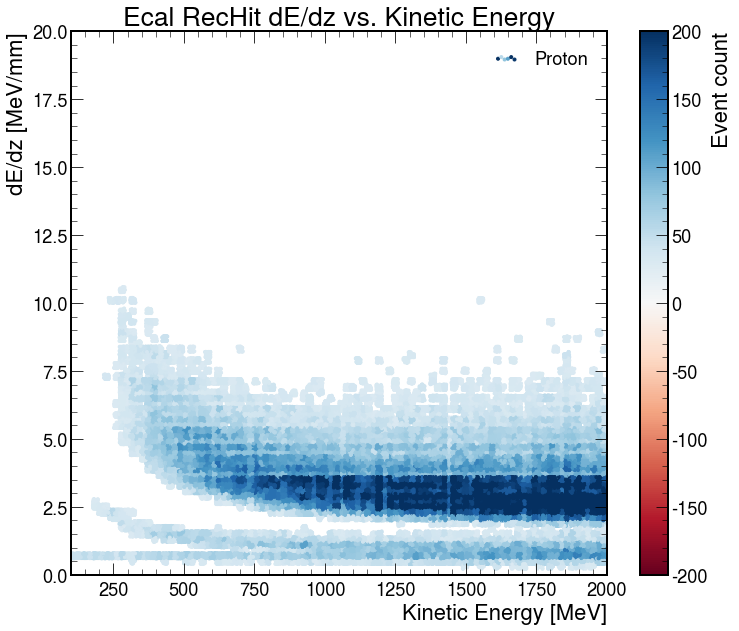

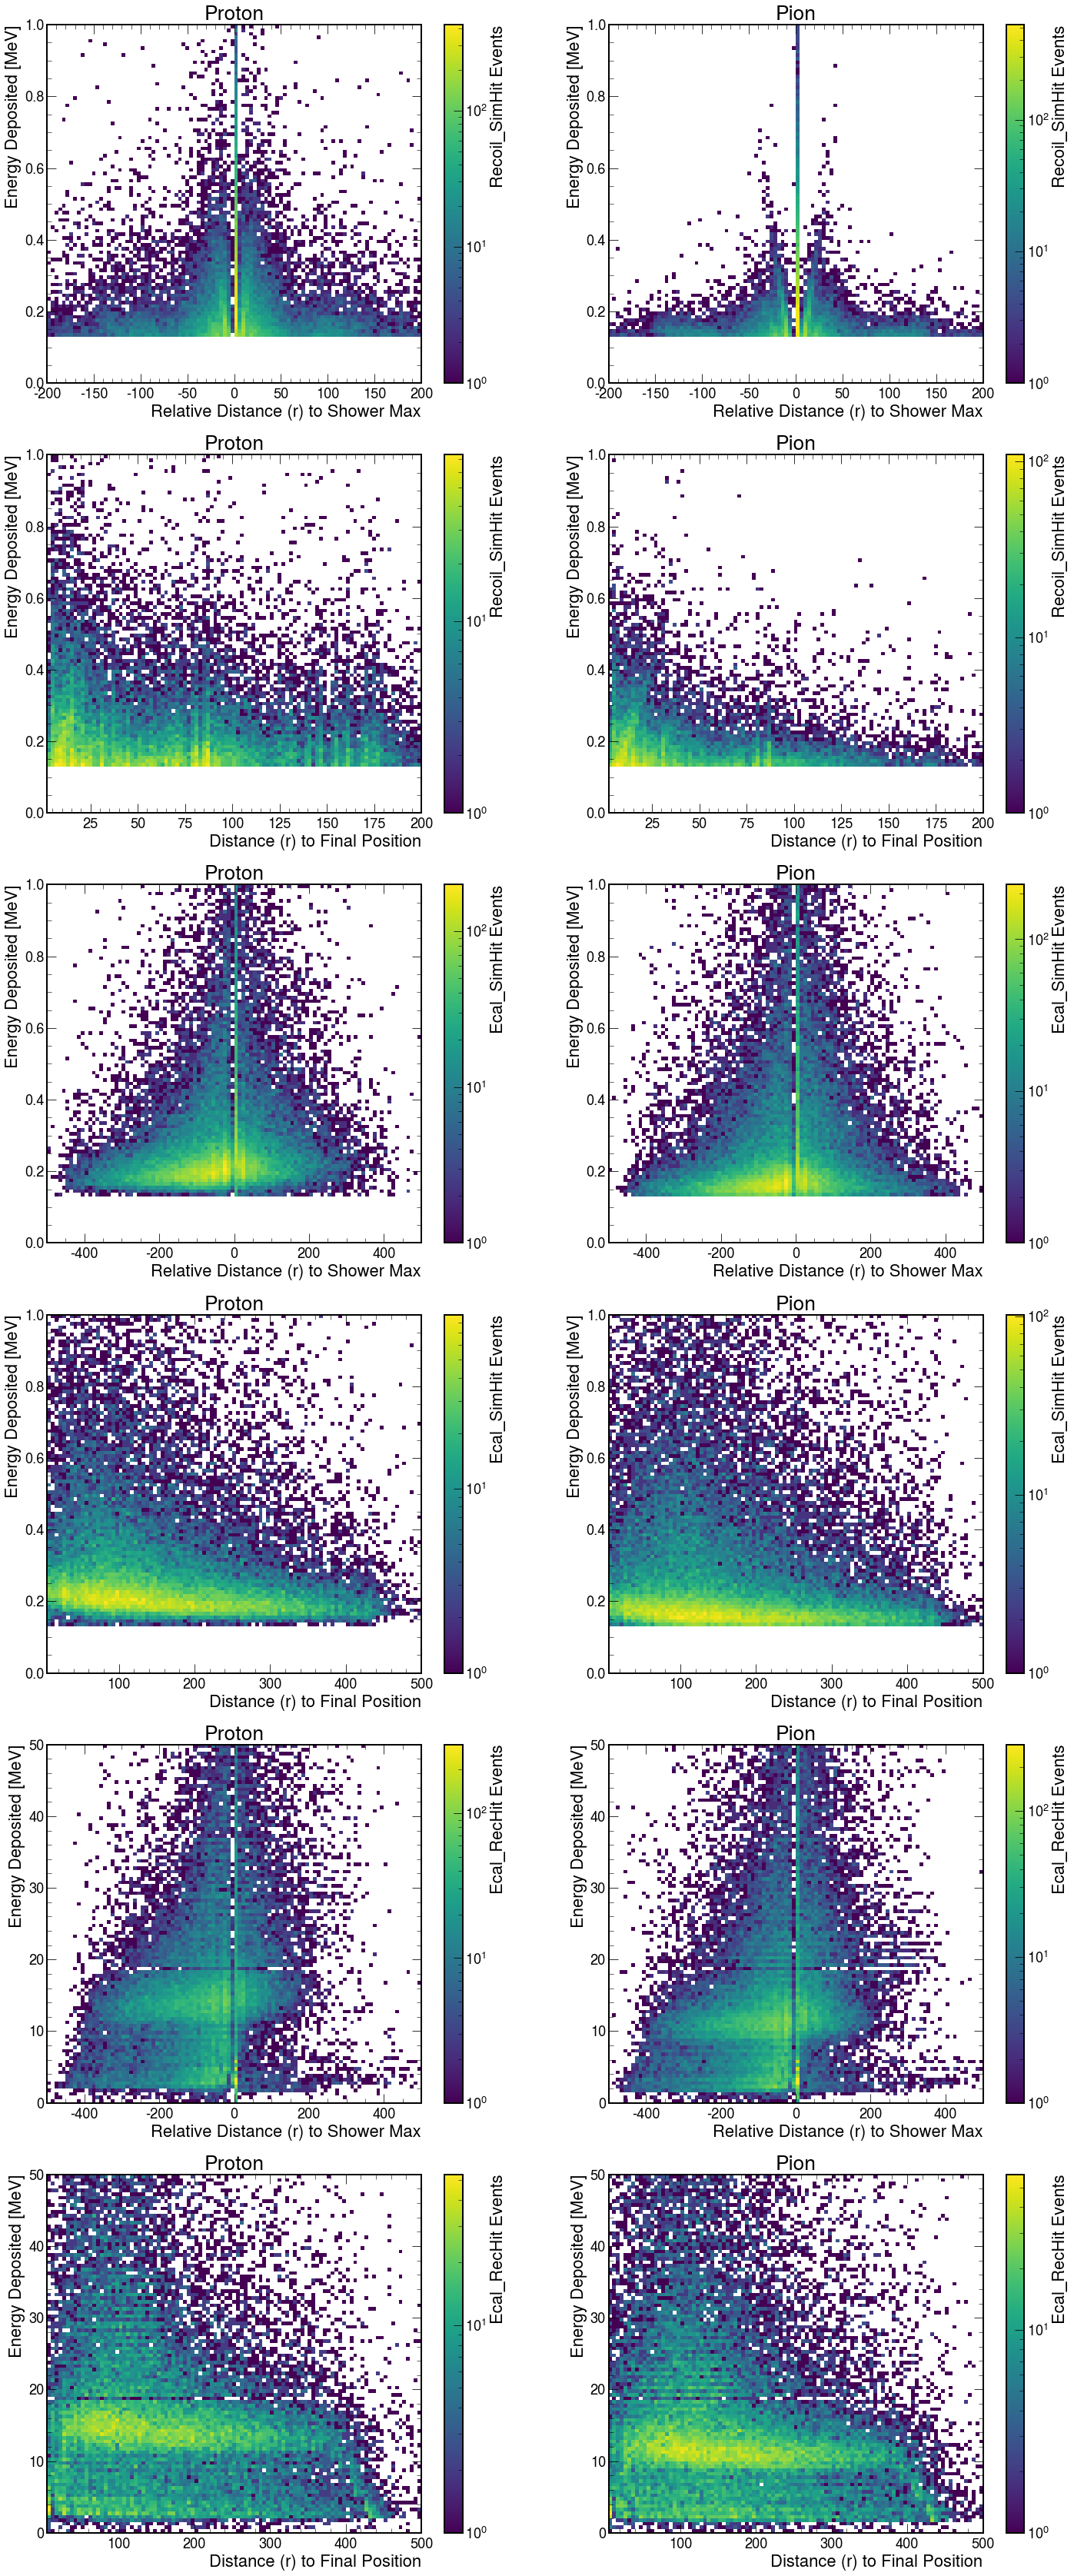

In [19]:
import ipywidgets as widgets
%matplotlib inline
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import cm
plt.rcParams.update({'font.size': 22})

#------------------------- Plot all graphs in hists --------------------------------
'''
i=0
for coll in hists.keys():
    for key in hists[coll]:
        if i%2==0:
            fig, ax=plt.subplots(ncols=2, figsize=(22,10))
        hist.plot1d(hists[coll][key], ax=ax[i%2], clear=False, overlay="particle")
        
        if (type(Labels[coll][key])==tuple):
            ax[i%2].set_xlabel(Labels[coll][key][0])
            ax[i%2].set_ylabel(Labels[coll][key][1])
        else:
            ax[i%2].set_xlabel(Labels[coll][key])
            
        i+=1
'''
#------------------------- Plotting Widget ----------------------------------------
'''
%matplotlib widget
#Makes a list of attributes for the widget
widlist=[[coll+"-"+attr for attr in branches[coll]] for coll in branches.keys()]
WidList=np.array([])
for i in widlist:
    WidList=np.append(WidList, i)


fig, axW=plt.subplots(figsize=(10,10))

def plott(attr, compare=True):
    coll=attr[:attr.find("-")]
    key=attr[attr.find("-")+1:]
    hist.plot1d(hists[coll][key], ax=axW, overlay="particle", clear=compare)#, legend_opts={'labels':[attr]})
    
    if (type(Labels[coll][key])==tuple):
        axW.set_xlabel(Labels[coll][key][0], fontsize=18)
        axW.set_ylabel(Labels[coll][key][1], fontsize=18)
    else:
        axW.set_xlabel(Labels[coll][key], fontsize=18)
        axW.set_ylabel(coll, size=18)
    #plt.close()
    #display(fig)
   
    
_=widgets.interact(plott, attr=WidList, compare=[("True",0),("False",1)]);
#'''

'''
%matplotlib widget


def kine4D()

'''
#------------------------------------- Plots ---------------------------------------------------
def twoDPlot(names):
    numP=len(names)
    fig, ax=plt.subplots(ncols=2, nrows=numP, figsize=(24, 10*numP))
    for i in range(0, numP):
        if names[i, 1]:
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle"), "s", ax=ax[i,0], clear=True, patch_opts={'norm': colors.LogNorm()})
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle"), "s", ax=ax[i,1], clear=True, patch_opts={'norm': colors.LogNorm()})
        else:
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle"), "s", ax=ax[i,0], clear=True)
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle"), "s", ax=ax[i,1], clear=True)
        
        ax[i, 0].set_title("Proton")
        ax[i, 1].set_title("Pion")
        
def scatterHist(data, histo, cutoff):
    newPro=[[],[]]
    newPio=[[],[]] 
    proZs=[]
    pioZs=[]
    
    for i in range(len(data["Proton"][0])):
        #Finds histogram bin for kine
        kineIndx=math.floor((data["Proton"][1][i]-100)/19)
        #Uses histogram to find bin for dedz
        dedzIndx=histo.axes()[1].index(data["Proton"][0][i])-1
        #If point is in histogram overflow bin, leave it
        if dedzIndx==100: continue
        freq=histo.values()[('Proton',)][dedzIndx][kineIndx]
        #If greater than five occurences add to new list, else drop. Additionally add the hist count to the Z-value array
    
        if freq>=cutoff:
            newPro[0].append(data["Proton"][0][i])
            newPro[1].append(data["Proton"][1][i])
            proZs.append(histo.values()[('Proton',)][dedzIndx][kineIndx])

    for i in range(len(data["Pion"][0])):
        kineIndx=math.floor((data["Pion"][1][i]-100)/19)
        dedzIndx=histo.axes()[1].index(data["Pion"][0][i])-1
        if dedzIndx==100: continue
        freq=histo.values()[('Pion',)][dedzIndx][kineIndx]
    
        if freq>=cutoff:
            newPio[0].append(data["Pion"][0][i])
            newPio[1].append(data["Pion"][1][i])
            pioZs.append((histo.values()[('Pion',)][dedzIndx][kineIndx])*-1)

    return newPro, newPio, proZs, pioZs


#--------------------------------------------------------------------------------------------------
#              All graphs have a MIP mask on them, all dEdz graphs currently lack a dz
#--------------------------------------------------------------------------------------------------
#'''
names=np.array([['recoil_dedzMIP', True], ['recoil_showerMax', False], ["recoil_sumEdep", False], ["recoil_avgEdep", False], ["recoil_depth", False],\
       ['ecalSim_dedzMIP', True], ['ecalSim_showerMax', False], ["ecalSim_sumEdep", False], ["ecalSim_avgEdep", False], ["ecalSim_depth", False],\
       ["ecalRec_dedzMIP", True], ['ecalRec_showerMax', False], ["ecalRec_sumE", False], ["ecalRec_avgE", False], ['ecalRec_amp', False], ['ecalRec_depth', False]])

#twoDPlot(names)
#twoDPlot(np.array([['ecalRec_showerMax', False], ['ecalRec_depth', False]]))


#--------------------------Special Graphs------------------------------------------------------------

#------------------ Recoil
#'''
newPro, newPio, proZs, pioZs=scatterHist(histsAdd["recoil_dedzScatter"], histsAdd["recoil_dedzMIP"], 30)

fig, ax=plt.subplots(figsize=(12,10))
plt.scatter(newPro[1], newPro[0], c=proZs, vmin=-100, vmax=100, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Proton")
plt.scatter(newPio[1], newPio[0], c=pioZs, vmin=-100, vmax=100, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Pion")
cbar=plt.colorbar(label= "Event count")

plt.legend(scatterpoints=6)
ax.set_title("Recoil Tracker dE/dz vs. Kinetic Energy")
ax.set_ylim([0,2])
ax.set_xlim([100,2000])
ax.set_xlabel("Kinetic Energy [MeV]")
ax.set_ylabel("dE/dz [MeV/mm]")

#'''
#------------------ Ecal SimHit
#'''
newPro, newPio, proZs, pioZs=scatterHist(histsAdd["ecalSim_dedzScatter"], histsAdd["ecalSim_dedzMIP"], 30)

fig, ax=plt.subplots(figsize=(12,10))
plt.scatter(newPro[1], newPro[0], c=proZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Proton")
#plt.scatter(newPio[1], newPio[0], c=pioZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Pion")
cbar=plt.colorbar(label= "Event count")

plt.legend(scatterpoints=6)
ax.set_title("Ecal SimHit dE/dz vs. Kinetic Energy")
ax.set_ylim([0,2])
ax.set_xlim([100,2000])
ax.set_xlabel("Kinetic Energy [MeV]")
ax.set_ylabel("dE/dz [MeV/mm]")
#'''
#----------------- Ecal RecHit
#'''
newPro, newPio, proZs, pioZs=scatterHist(histsAdd["ecalRec_dedzScatter"], histsAdd["ecalRec_dedzMIP"], 30)

fig, ax=plt.subplots(figsize=(12,10))
plt.scatter(newPro[1], newPro[0], c=proZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Proton")
#plt.scatter(newPio[1], newPio[0], c=pioZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Pion")
cbar=plt.colorbar(label= "Event count")

plt.legend(scatterpoints=6)
ax.set_title("Ecal RecHit dE/dz vs. Kinetic Energy")
ax.set_ylim([0,20])
ax.set_xlim([100,2000])
ax.set_xlabel("Kinetic Energy [MeV]")
ax.set_ylabel("dE/dz [MeV/mm]")
#'''

fig, ax=plt.subplots(ncols=2, nrows=6, figsize=(24, 60))
#[:,:,:499]

#--------------- Recoil 
#'''
hist.plot2d(histsAdd['recoil_residualMax']["Proton"].sum("particle")[:,:,1525:2000].sum("p"), "s", ax=ax[0, 0], clear=True,  patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd['recoil_residualMax']["Pion"].sum("particle")[:,:,1525:2000].sum("p"), "s", ax=ax[0, 1], clear=True,  patch_opts={'norm': colors.LogNorm()})
ax[0, 0].set_title("Proton")
ax[0, 1].set_title("Pion")

hist.plot2d(histsAdd['recoil_residualLast']["Proton"].sum("particle")[:,2:,1525:2000].sum("p"), "s", ax=ax[1, 0], clear=True,  patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd['recoil_residualLast']["Pion"].sum("particle")[:,2:,1525:2000].sum("p"), "s", ax=ax[1, 1], clear=True,  patch_opts={'norm': colors.LogNorm()})
ax[1, 0].set_title("Proton")
ax[1, 1].set_title("Pion")

#'''
#'''
#-------------- Ecal SimHit
hist.plot2d(histsAdd['ecalSim_residualMax']["Proton"].sum("particle")[:,:,765:1050].sum("p"), "s", ax=ax[2, 0], clear=True,  patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd['ecalSim_residualMax']["Pion"].sum("particle")[:,:,765:1050].sum("p"), "s", ax=ax[2, 1], clear=True,  patch_opts={'norm': colors.LogNorm()})
ax[2, 0].set_title("Proton")
ax[2, 1].set_title("Pion")

hist.plot2d(histsAdd['ecalSim_residualLast']["Proton"].sum("particle")[:,5:,765:1050].sum("p"), "s", ax=ax[3, 0], clear=True,  patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd['ecalSim_residualLast']["Pion"].sum("particle")[:,5:,765:1050].sum("p"), "s", ax=ax[3, 1], clear=True,  patch_opts={'norm': colors.LogNorm()})
ax[3, 0].set_title("Proton")
ax[3, 1].set_title("Pion")
#'''

#-------------- Ecal RecHit
#'''
hist.plot2d(histsAdd['ecalRec_residualMax']["Proton"].sum("particle")[:,:,765:1050].sum("p"), "s", ax=ax[4, 0], clear=True,  patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd['ecalRec_residualMax']["Pion"].sum("particle")[:,:,765:1050].sum("p"), "s", ax=ax[4, 1], clear=True,  patch_opts={'norm': colors.LogNorm()})
ax[4, 0].set_title("Proton")
ax[4, 1].set_title("Pion")

hist.plot2d(histsAdd['ecalRec_residualLast']["Proton"].sum("particle")[:,5:,765:1050].sum("p"), "s", ax=ax[5, 0], clear=True,  patch_opts={'norm': colors.LogNorm()})
hist.plot2d(histsAdd['ecalRec_residualLast']["Pion"].sum("particle")[:,5:,765:1050].sum("p"), "s", ax=ax[5, 1], clear=True,  patch_opts={'norm': colors.LogNorm()})
ax[5, 0].set_title("Proton")
ax[5, 1].set_title("Pion")
#'''

plt.show()

In [9]:
"""
#------------------------------------------------------------------------------------------------------
#----------------------------------ROC Curves----------------------------------------------------------
#------------------------------------------------------------------------------------------------------
from sklearn import metrics

piondedz=histsAdd['ecalSim_dedzKine'].values()[('Pion',)]
protondedz=histsAdd['ecalSim_dedzKine'].values()[('Proton',)]
#print(piondedz)
#print(protondedz)


#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)
#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))
#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the
#y_score, and sample_weights=targetWeights

#Creates y_true binary array
def parLabel(arr, pdgID):
    return [pdgID for x in arr]

#tacks on arr2 to arr1 at the innermost dimension
def merge(arr1, arr2):
    return np.append(arr1, arr2, axis=-1)
    

#Generates ROC curves given 2d histogram arrays for proton and pion.
def ROCKdat(proton, pion, lower, upper):
    arrsize=len(proton)
    bigtrue=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigscore=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigweights=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    step=upper/arrsize
    
    proWeights=proton
    pioWeights=pion
    proLabels=parLabel(proton, 2212)
    pioLabels=parLabel(pion, 211)
    
    #Used for determining array indices
    counter=arrsize
    for i in np.arange(0, arrsize):
        y_true=merge(proLabels[i:],pioLabels[i:])
        #Check This
        if (all(proWeights[i:]==0)):
            proton_prob=0.000001
        else:
            proton_prob=np.sum(proWeights[i:])/(np.sum(proWeights[i:])+np.sum(pioWeights[i:]))
        y_score=[proton_prob]*(arrsize-i)*2
        weights=merge(proWeights[i:], pioWeights[i:])
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        bigtrue[lo:up]=y_true
        bigscore[lo:up]=y_score
        bigweights[lo:up]=weights
        counter-=1
        
    #print(bigtrue)
    return bigtrue, bigscore, bigweights
                                    
    
#For 2d histogram arrays, the rows are the de/dz, the columns are kine. 
def threeROC(histogram, numROC, fig, upper):
    proton=histogram.values()[('Proton',)]
    pion=histogram.values()[('Pion',)]
    kinesize=len(proton)
    step=kinesize/numROC
    
    for i in np.linspace(step, kinesize, numROC):
        lo=math.floor(i-step)
        up=math.floor(i)
        ytru, ysco, weig=ROCKdat(np.ndarray.flatten(proton[:, lo:up]), np.ndarray.flatten(pion[:, lo:up]), 0, upper)
        fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)
        plt.plot(fpr, tpr, figure=fig, label="{}-{}GeV".format(0.1+round((i-step)*0.019, 3), round(0.1+i*0.019, 3)))
    
    
    
#'''  
fig1, ax1=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalSim_dedzKine"], 5, fig1, 0.2) 
plt.plot([0,1],[0,1],"--", figure=fig1, label="Random Classifier")
fig1.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Recoil tracker, dE/dz vs Kinetic Energy classification, TPR for Protons"
fig1.suptitle(title, ha='center', y=0.05, fontsize=14)
ax1.set_ylabel("TPR")
ax1.set_xlabel("FPR")
#'''

#'''
fig2, ax2=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["recoil_dedzKine"], 5, fig2, 0.2)
plt.plot([0,1],[0,1],"--", figure=fig2, label="Random Classifier")
fig2.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal SimHit, dE/dz vs Kinetic Energy classification, TPR for Protons"
fig2.suptitle(title, ha='center', y=0.05, fontsize=14)
ax2.set_ylabel("TPR")
ax2.set_xlabel("FPR")
#'''

#'''
fig3, ax3=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalRec_avgAmpKine"], 5, fig3, 0.8)
plt.plot([0,1],[0,1],"--", figure=fig3, label="Random Classifier")
fig3.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal RecHit, Event Average Amplitude vs Kinetic Energy classification, TPR for Protons"
fig3.suptitle(title, ha='center', y=0.05, fontsize=14)
ax3.set_ylabel("TPR")
ax3.set_xlabel("FPR")
#'''    
    
#ytru, ysco, weig= ROCKdat(protondedz, piondedz, 0, 0.30)
#fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)

#fig2, ax2=plt.subplots()
#plt.plot(fpr, tpr, figure=fig2)
"""

'\n#------------------------------------------------------------------------------------------------------\n#----------------------------------ROC Curves----------------------------------------------------------\n#------------------------------------------------------------------------------------------------------\nfrom sklearn import metrics\n\npiondedz=histsAdd[\'ecalSim_dedzKine\'].values()[(\'Pion\',)]\nprotondedz=histsAdd[\'ecalSim_dedzKine\'].values()[(\'Proton\',)]\n#print(piondedz)\n#print(protondedz)\n\n\n#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)\n#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))\n#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the\n#y_score, and sample_weights=targetWeights\n\n#Creates y_true binary array\ndef parLabel(arr, pdgID